# BA820 Project – Milestone 4: Systematic Evaluation of Global Palette Structure in Bob Ross Paintings

## Research Question (M4)
**Do Bob Ross paintings exhibit stable, reproducible hard cluster boundaries in palette usage, or is palette variation better described as continuous similarity with only small peripheral groups?**

## Why this matters
Bob Ross paintings are often described as visually consistent. If that consistency reflects a small number of recurring palette “types,” then we should see clear, reproducible clusters under reasonable unsupervised settings. If not, then palette usage may be better treated as a continuous similarity space, which changes how we summarize paintings and how we would retrieve “most similar” works.

## What this milestone does
This milestone strengthens the analysis by using course-based methods and **systematic evaluation**:
- Use a **binary pigment matrix** (used vs. not used)
- Measure similarity with **Jaccard distance** (appropriate for binary set overlap)
- Use **hierarchical clustering** as the main distance-based method
- Stress-test results across **linkage choices**, **k cuts**, and a **high-frequency pigment variant** (Titanium White when available)
- Use **PCA** as a supporting visualization
- Add a **K-means baseline** with elbow/silhouette diagnostics for cross-method comparison

The goal is not to force an “optimal” segmentation, but to evaluate whether any global cluster boundaries are stable under reasonable alternatives and standard diagnostics.

## Brief context (M2–M3) and what M4 improves

In **Milestone 2 (M2)**, I established the baseline pipeline for this project: represent each painting as **binary pigment usage**, compute **pairwise Jaccard distances**, and use **hierarchical clustering** as an initial global view of palette similarity structure. M2 was intentionally exploratory and focused on setting up a consistent similarity framework and interpretable summaries.

In **Milestone 3 (M3)**, I kept the same core pipeline but reframed the task as a **robustness question**. Specifically, I examined whether cluster structure changes under reasonable alternatives, including **linkage choice** (e.g., average vs. complete), **cut levels** (e.g., k=4 and k=6), and a **feature variant** (excluding Titanium White when available). I also used **PCA** as a supporting visualization to help interpret whether clusters appear separable in a low-dimensional projection.

**Milestone 4 (M4)** strengthens these earlier milestones by making the evaluation more systematic and harder to “cherry-pick.” The main improvements in M4 are:
1) **Clearer evaluation and tuning**: rather than relying on a small number of k values, I run **k-sweeps** and track course-standard diagnostics (e.g., silhouette trends and cluster balance) to assess whether any “natural” segmentation emerges.
2) **Cross-method comparison**: I add a course-based alternative clustering approach (**K-means**) and use **elbow/inertia** and **silhouette** diagnostics to check whether the global structure is consistent across methods.
3) **More explicit documentation of what was tried**: I organize the analysis as controlled comparisons (linkage, k, and feature variants) so conclusions depend on patterns that persist across settings rather than any single configuration.

### Step 1 — Construct the Pigment Feature Matrix
I treat each painting as a vector of binary pigment indicators (1 = used, 0 = not used). This representation matches the question because we care about which pigments appear in a painting’s palette, not how many times they appear.

In [16]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [17]:
import pandas as pd

df = pd.read_csv("/content/bob_ross.csv")

pigment_cols = df.columns[9:].tolist()
X = df[pigment_cols].copy()

print("Data shape:", df.shape)
print("Pigment matrix shape:", X.shape)
print("Pigment columns:", pigment_cols)

is_binary = all(set(X[c].dropna().unique().tolist()).issubset({0, 1}) for c in pigment_cols)
print("All pigment columns are binary (0/1):", is_binary)

for c in pigment_cols:
    print(c, sorted(X[c].dropna().unique().tolist()))

Data shape: (403, 27)
Pigment matrix shape: (403, 18)
Pigment columns: ['Black_Gesso', 'Bright_Red', 'Burnt_Umber', 'Cadmium_Yellow', 'Dark_Sienna', 'Indian_Red', 'Indian_Yellow', 'Liquid_Black', 'Liquid_Clear', 'Midnight_Black', 'Phthalo_Blue', 'Phthalo_Green', 'Prussian_Blue', 'Sap_Green', 'Titanium_White', 'Van_Dyke_Brown', 'Yellow_Ochre', 'Alizarin_Crimson']
All pigment columns are binary (0/1): True
Black_Gesso [False, True]
Bright_Red [False, True]
Burnt_Umber [False, True]
Cadmium_Yellow [False, True]
Dark_Sienna [False, True]
Indian_Red [False, True]
Indian_Yellow [False, True]
Liquid_Black [False, True]
Liquid_Clear [False, True]
Midnight_Black [False, True]
Phthalo_Blue [False, True]
Phthalo_Green [False, True]
Prussian_Blue [False, True]
Sap_Green [False, True]
Titanium_White [False, True]
Van_Dyke_Brown [False, True]
Yellow_Ochre [False, True]
Alizarin_Crimson [False, True]


### Step 2 — Compute Jaccard Distances and Build a Baseline Dendrogram

To compare palettes, I compute **pairwise Jaccard distance** between paintings. Because pigments are encoded as binary indicators, Jaccard focuses on **shared pigment presence** and does not overweight joint absences (which are common in sparse binary data).

I then build a baseline **hierarchical clustering dendrogram** (average linkage) using the Jaccard distance matrix. This provides an initial global view of whether the palette space shows clear separations or whether paintings form one dominant similarity region.

Condensed distance shape: (81003,)
Square distance shape: (403, 403)
Mean Jaccard distance: 0.36538496737070536
Min/Max Jaccard distance: 0.0 1.0


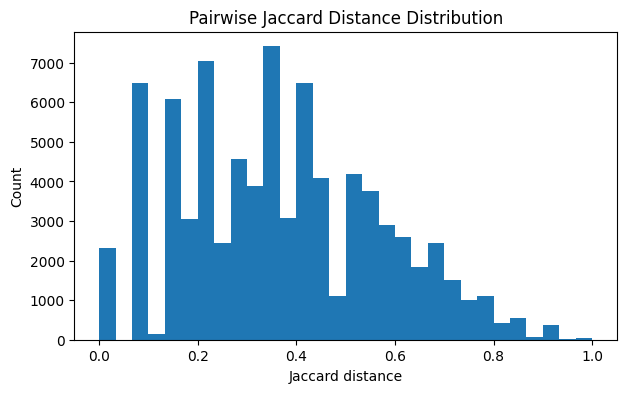

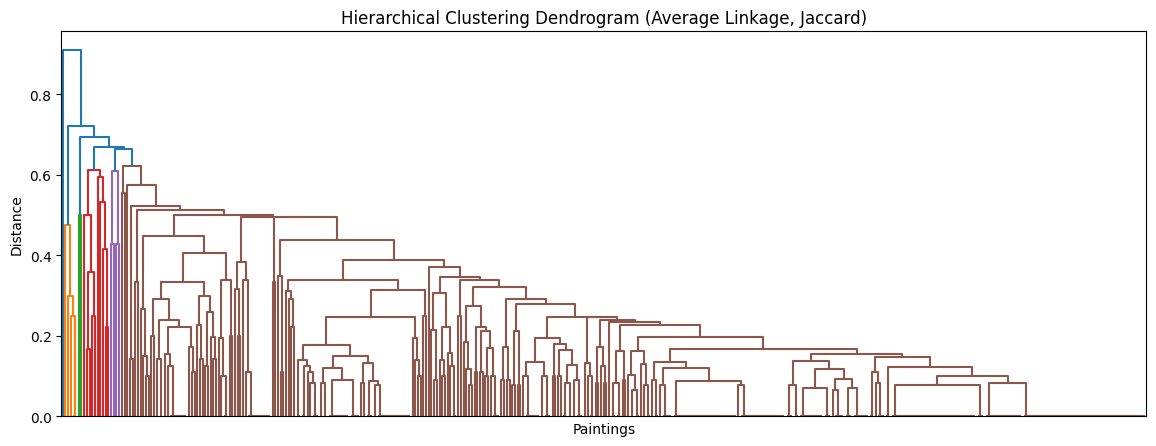

In [18]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

D_condensed = pdist(X.values, metric="jaccard")
D_square = squareform(D_condensed)

print("Condensed distance shape:", D_condensed.shape)
print("Square distance shape:", D_square.shape)
print("Mean Jaccard distance:", D_condensed.mean())
print("Min/Max Jaccard distance:", D_condensed.min(), D_condensed.max())

plt.figure(figsize=(7,4))
plt.hist(D_condensed, bins=30)
plt.title("Pairwise Jaccard Distance Distribution")
plt.xlabel("Jaccard distance")
plt.ylabel("Count")
plt.show()

Z_avg = linkage(D_condensed, method="average")
plt.figure(figsize=(14,5))
dendrogram(Z_avg, no_labels=True, color_threshold=None)
plt.title("Hierarchical Clustering Dendrogram (Average Linkage, Jaccard)")
plt.xlabel("Paintings")
plt.ylabel("Distance")
plt.show()

### Step 3 — Stability and Sensitivity Checks (course-based)

To test whether global hard cluster boundaries are **reproducible**, I treat clustering as a robustness question. Holding the same data representation and distance framework fixed (binary pigments + Jaccard), I vary key modeling choices:

- **Linkage**: average vs. complete  
- **Cut level (k)**: k = 4 vs. k = 6  
- **Feature variant**: with vs. without Titanium White (when the column is available)

For each setting, I report:
1) **Silhouette score (Jaccard)** as a course-standard diagnostic of cohesion vs. separation  
2) **Cluster balance** (cluster sizes and the proportion in the largest cluster) to quantify dominance/imbalance

In [19]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score

pigment_cols = df.columns[9:].tolist()
X_full = df[pigment_cols].copy()

def run_cluster_eval(X, linkage_method, k):
    D = pdist(X.values, metric="jaccard")
    Z = linkage(D, method=linkage_method)
    labels = fcluster(Z, t=k, criterion="maxclust")
    sil = silhouette_score(X.values, labels, metric="jaccard")
    return labels, sil

results = []

for lm in ["average", "complete"]:
    for k in [4, 6]:
        labels, sil = run_cluster_eval(X_full, lm, k)
        results.append({
            "version": "with_TW",
            "linkage": lm,
            "k": k,
            "silhouette_jaccard": sil,
            "labels": labels
        })

tw_candidates = [c for c in X_full.columns if c.lower().replace(" ", "").replace("_","") in ["titaniumwhite", "titaniumwhite(1)"]]
if len(tw_candidates) == 0:
    tw_candidates = [c for c in X_full.columns if "titanium" in c.lower() and "white" in c.lower()]

if tw_candidates:
    tw_col = tw_candidates[0]
    X_no_tw = X_full.drop(columns=[tw_col]).copy()

    for lm in ["average", "complete"]:
        for k in [4, 6]:
            labels, sil = run_cluster_eval(X_no_tw, lm, k)
            results.append({
                "version": "without_TW",
                "linkage": lm,
                "k": k,
                "silhouette_jaccard": sil,
                "labels": labels
            })
else:
    print("Titanium White column not found; skipping without_TW comparison.")

summary = pd.DataFrame([{k:v for k,v in r.items() if k!="labels"} for r in results])
print(summary.sort_values(["version","linkage","k"]).to_string(index=False))

   version  linkage  k  silhouette_jaccard
   with_TW  average  4            0.470907
   with_TW  average  6            0.455069
   with_TW complete  4            0.351004
   with_TW complete  6            0.335955
without_TW  average  4            0.482794
without_TW  average  6            0.460355
without_TW complete  4            0.282925
without_TW complete  6            0.284907


In [20]:
rows = []
for r in results:
    labels = r["labels"]
    counts = pd.Series(labels).value_counts().sort_index()
    max_prop = counts.max() / counts.sum()

    row = {
        "version": r["version"],
        "linkage": r["linkage"],
        "k": r["k"],
        "n_clusters": counts.shape[0],
        "max_cluster_size": int(counts.max()),
        "max_cluster_prop": float(max_prop)
    }

    for i, (cid, cnt) in enumerate(counts.items(), start=1):
        row[f"c{i}_size"] = int(cnt)

    rows.append(row)

cluster_balance = pd.DataFrame(rows).sort_values(["version","linkage","k"]).reset_index(drop=True)
display(cluster_balance)

,version,linkage,k,n_clusters,max_cluster_size,max_cluster_prop,c1_size,c2_size,c3_size,c4_size,c5_size,c6_size
0,with_TW,average,4,4,395,0.980149,5,2,395,1,NaN,NaN
1,with_TW,average,6,6,381,0.945409,5,2,10,4,381.0,1.0
2,with_TW,complete,4,4,331,0.821340,331,15,44,13,NaN,NaN
3,with_TW,complete,6,6,331,0.821340,331,14,1,44,6.0,7.0
4,without_TW,average,4,4,394,0.977667,6,2,394,1,NaN,NaN
5,without_TW,average,6,6,383,0.950372,6,2,2,9,383.0,1.0
6,without_TW,complete,4,4,315,0.781638,315,61,9,18,NaN,NaN
7,without_TW,complete,6,6,300,0.744417,15,300,6,55,9.0,18.0


### Step 3 Results (What we learn)

Across conditions, the clustering solutions are consistently dominated by one majority cluster. Under average linkage, the largest cluster contains roughly 95–98% of paintings (e.g., 395/403 for k=4 and 381/403 for k=6), both with and without Titanium White. Under complete linkage, the dominance is less extreme but still substantial (about 74–82%), and removing Titanium White reduces imbalance only modestly.

This pattern suggests that the global palette space does not naturally separate into several balanced, well-separated groups. Instead, it is better characterized as one dominant similarity region with a small number of peripheral clusters or outliers, providing limited support for strong global hard cluster boundaries.

### Step 4 — PCA Visualization for Cluster Interpretation

I use PCA as a supporting visualization to interpret global structure in a low-dimensional view. PCA projects the high-dimensional pigment space onto directions that explain the most variance, which makes it easier to see whether cluster labels form separated regions or remain heavily overlapping.

Below, points represent paintings in the first two principal components, colored by hierarchical cluster assignments (k=4 and k=6).

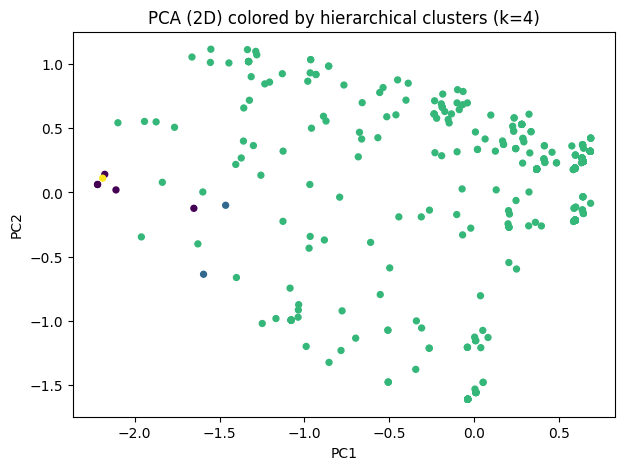

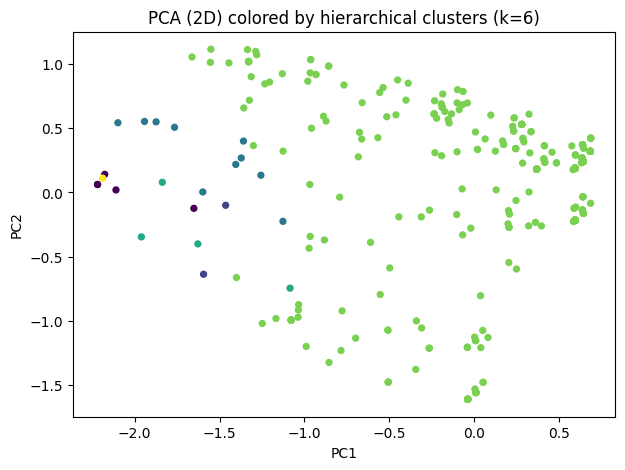

Explained variance ratio (PC1, PC2): [0.23180513 0.18630154]
Total explained variance (PC1+PC2): 0.41810666416849085


In [21]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster

D = pdist(X.values, metric="jaccard")
Z = linkage(D, method="average")
labels_k4 = fcluster(Z, t=4, criterion="maxclust")
labels_k6 = fcluster(Z, t=6, criterion="maxclust")

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.values)

plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_k4, s=18)
plt.title("PCA (2D) colored by hierarchical clusters (k=4)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_k6, s=18)
plt.title("PCA (2D) colored by hierarchical clusters (k=6)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_)
print("Total explained variance (PC1+PC2):", pca.explained_variance_ratio_.sum())

### Step 4 Conclusion (PCA)

In the 2D PCA projection, hierarchical cluster labels for both k=4 and k=6 show substantial overlap rather than clearly separated “islands.” Even when forcing a 4- or 6-way partition, the groups are not strongly separable along the primary directions of variance.

The first two principal components explain approximately 23.2% (PC1) and 18.6% (PC2) of the variance (about 41.8% combined). While this captures a meaningful portion of overall variation, the absence of clear separation in this low-dimensional view is consistent with a continuous similarity structure rather than a small set of stable, globally distinct palette archetypes.

## Step 5 — K-means Clustering with Elbow and Silhouette Diagnostics

In this step, I run **K-means clustering** as an additional unsupervised approach and evaluate a range of k values.  
I use the **elbow plot (inertia/SSE vs. k)** to assess diminishing returns as k increases, and the **silhouette score vs. k** to evaluate how well-separated the resulting clusters are.

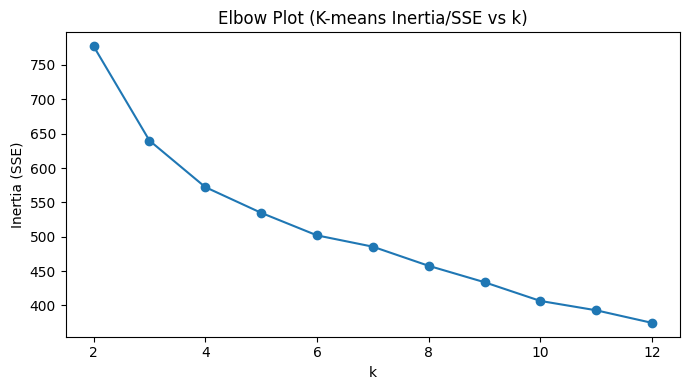

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

ks = list(range(2, 13))
X_km = X.values.astype(float)

inertias = []
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_km)
    inertias.append(km.inertia_)

plt.figure(figsize=(7,4))
plt.plot(ks, inertias, marker="o")
plt.title("Elbow Plot (K-means Inertia/SSE vs k)")
plt.xlabel("k")
plt.ylabel("Inertia (SSE)")
plt.tight_layout()
plt.show()


The inertia curve drops most sharply from **k=2 to k=4**, then shows clear diminishing returns beyond roughly **k≈4–6**. This suggests that if we want a coarse, compact partition under K-means, k in the **4–6** range is a reasonable candidate set; larger k mainly provides finer splits rather than a strong structural change.

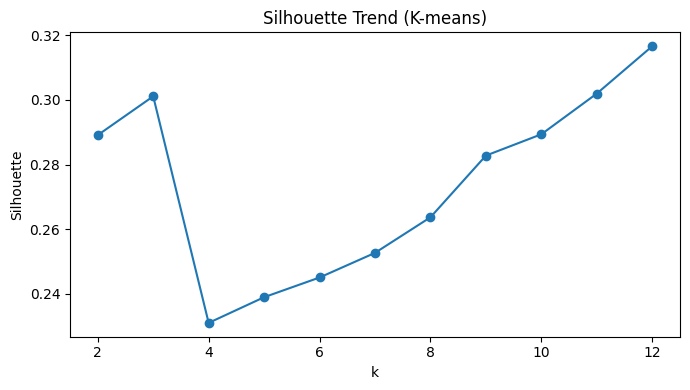

In [23]:
from sklearn.metrics import silhouette_score

sil_km = []
labels_store = {}

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_km)
    labels_store[k] = labels
    sil = silhouette_score(X_km, labels, metric="euclidean")
    sil_km.append(sil)

plt.figure(figsize=(7,4))
plt.plot(ks, sil_km, marker="o")
plt.title("Silhouette Trend (K-means)")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.tight_layout()
plt.show()

Silhouette does not identify a single clearly dominant “natural” k. There is a local peak at k=3, followed by a sharp drop at k=4, and then a gradual increase as k grows larger (highest within the tested range at k=12).

Importantly, the improvement at larger k appears gradual and reflects finer partitioning rather than the emergence of sharply separated global groups. Overall, this pattern is more consistent with incremental refinement than with a small number of strongly separated archetypes.

In [24]:
import pandas as pd

rows = []
for k in ks:
    labels = labels_store[k]
    counts = pd.Series(labels).value_counts().sort_index()
    max_prop = counts.max() / counts.sum()
    rows.append({
        "method": "kmeans",
        "k": k,
        "n_clusters": int(counts.shape[0]),
        "max_cluster_prop": float(max_prop),
        "max_cluster_size": int(counts.max())
    })

kmeans_balance = pd.DataFrame(rows)
display(kmeans_balance)

,method,k,n_clusters,max_cluster_prop,max_cluster_size
0,kmeans,2,2,0.764268,308
1,kmeans,3,3,0.647643,261
2,kmeans,4,4,0.411911,166
3,kmeans,5,5,0.320099,129
4,kmeans,6,6,0.292804,118
5,kmeans,7,7,0.372208,150
6,kmeans,8,8,0.203474,82
7,kmeans,9,9,0.151365,61
8,kmeans,10,10,0.210918,85
9,kmeans,11,11,0.183623,74


### What Step 5 adds

Step 5 strengthens the analysis by providing a course-based cross-method check. If global hard cluster boundaries were strong, we would expect K-means diagnostics to point to a clear small k and produce reasonably separated clusters. Instead, elbow suggests only a broad candidate range (around **4–6**) while silhouette does not reveal a single dominant optimum and changes gradually across k. Combined with the hierarchical balance results, this supports the interpretation that global structure is dominated by a main palette region with only limited evidence for multiple well-separated archetypes.

## Step 6 — Better Tuning for Hierarchical Clustering (k-sweep)

To make the hierarchical evaluation more systematic, I sweep **k = 2 to 12** and track:
1) **Silhouette (Jaccard)** as a course diagnostic  
2) **Largest-cluster proportion** to quantify dominance/imbalance

I repeat the sweep for different linkage choices and (when available) the Titanium White feature variant.

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score
pigment_cols = df.columns[9:].tolist()
X_full = df[pigment_cols].copy()

tw_candidates = [c for c in X_full.columns if c.lower().replace(" ", "").replace("_","") in ["titaniumwhite", "titaniumwhite(1)"]]
if len(tw_candidates) == 0:
    tw_candidates = [c for c in X_full.columns if "titanium" in c.lower() and "white" in c.lower()]

X_variants = [("with_TW", X_full)]
if tw_candidates:
    tw_col = tw_candidates[0]
    X_no_tw = X_full.drop(columns=[tw_col]).copy()
    X_variants.append(("without_TW", X_no_tw))
else:
    print("Titanium White column not found; running only with_TW variant.")

linkages = ["average", "complete"]
ks = list(range(2, 13))

rows = []
for vname, Xv in X_variants:
    Dv = pdist(Xv.values, metric="jaccard")
    for lm in linkages:
        Zv = linkage(Dv, method=lm)
        for k in ks:
            labels = fcluster(Zv, t=k, criterion="maxclust")

            n_labels = len(np.unique(labels))
            if n_labels < 2:
                sil = np.nan
            else:
                sil = silhouette_score(Xv.values, labels, metric="jaccard")

            counts = pd.Series(labels).value_counts()
            max_prop = counts.max() / counts.sum()

            rows.append({
                "version": vname,
                "linkage": lm,
                "k": k,
                "n_labels": n_labels,
                "silhouette_jaccard": float(sil) if not np.isnan(sil) else np.nan,
                "max_cluster_prop": float(max_prop)
            })

sweep_df = pd.DataFrame(rows)
display(sweep_df.head(10))

,version,linkage,k,n_labels,silhouette_jaccard,max_cluster_prop
0,with_TW,average,2,2,0.597944,0.997519
1,with_TW,average,3,3,0.498231,0.985112
2,with_TW,average,4,4,0.470907,0.980149
3,with_TW,average,5,5,0.466916,0.955335
4,with_TW,average,6,6,0.455069,0.945409
5,with_TW,average,7,7,0.431152,0.940447
6,with_TW,average,8,8,0.424071,0.940447
7,with_TW,average,9,9,0.407405,0.940447
8,with_TW,average,10,10,0.402919,0.940447
9,with_TW,average,11,11,0.367931,0.937965


### Step 6 Conclusion (Hierarchical k-sweep)

If stable hard cluster boundaries existed, we would expect a moderate k at which silhouette peaks clearly (beyond the trivial smallest k) and the largest-cluster proportion moves toward a more balanced partition as k increases.

Instead, silhouette is highest at very small k (0.598 at k=2) and steadily declines thereafter. At the same time, cluster imbalance remains extreme across the full range: the largest cluster consistently contains roughly 94–100% of paintings.

Increasing k primarily fragments a small minority of paintings while leaving the dominant mass intact. This tuning behavior does not reveal a clear “natural” segmentation and is inconsistent with multiple stable global archetypes. Rather, it reinforces the interpretation of a single dominant similarity region with limited peripheral variation.

### What did not work as expected

Despite testing multiple linkage methods, k ranges, and feature variants, no configuration produced balanced, well-separated clusters. Increasing k did not reveal hidden archetypes; instead, it mainly fragmented small peripheral groups. This was somewhat surprising given the visual consistency often attributed to Bob Ross paintings.

## Step 7 — Local Co-occurrence Check (Apriori as a Supplement)

So far, the results provide limited support for **stable global hard cluster boundaries**. As a complementary check, I test whether palette structure is better described by **recurring local co-occurrence “recipes”**—small sets of pigments that tend to appear together across paintings.

To make this step interpretable (and to avoid rules being dominated by a near-universal pigment), I run Apriori on a **no–Titanium White** variant, restrict itemsets to **max length = 3**, and then filter rules by **minimum lift and confidence**. This step does **not** claim global archetypes; it asks whether the “one dominant region + peripheral variation” picture can coexist with stable local modules.


In [30]:
!pip -q install mlxtend
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

df_bool = X_full.drop(columns=["Titanium_White"]).astype(bool)

frequent_itemsets = apriori(df_bool, min_support=0.20, use_colnames=True, max_len=3)
print("n frequent itemsets:", frequent_itemsets.shape[0])

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

rules_f = rules[
    (rules["lift"] >= 1.2) &
    (rules["confidence"] >= 0.6) &
    (rules["antecedents"].apply(len) <= 2) &
    (rules["consequents"].apply(len) <= 2)
].copy()

print("rules filtered:", rules_f.shape)
rules_f.sort_values(["lift","confidence"], ascending=[False, False])[
    ["antecedents","consequents","support","confidence","lift"]
].head(15)

n frequent itemsets: 283
rules filtered: (89, 14)


,antecedents,consequents,support,confidence,lift
97,(Phthalo_Green),"(Sap_Green, Prussian_Blue)",0.205955,0.715517,1.393012
54,(Dark_Sienna),"(Midnight_Black, Van_Dyke_Brown)",0.707196,0.982759,1.356342
53,"(Midnight_Black, Van_Dyke_Brown)",(Dark_Sienna),0.707196,0.976027,1.356342
15,(Phthalo_Green),"(Prussian_Blue, Bright_Red)",0.200993,0.698276,1.340025
29,(Phthalo_Green),"(Cadmium_Yellow, Prussian_Blue)",0.210918,0.732759,1.318311
31,"(Indian_Yellow, Midnight_Black)",(Dark_Sienna),0.555831,0.941176,1.307911
32,(Dark_Sienna),"(Indian_Yellow, Midnight_Black)",0.555831,0.772414,1.307911
57,"(Yellow_Ochre, Midnight_Black)",(Dark_Sienna),0.627792,0.940520,1.306999
58,(Dark_Sienna),"(Yellow_Ochre, Midnight_Black)",0.627792,0.872414,1.306999
34,"(Dark_Sienna, Sap_Green)",(Indian_Yellow),0.501241,0.935185,1.290684


### Step 7 Conclusion (Apriori)

Applying Apriori to the no–Titanium White variant yields a manageable set of recurring local patterns (283 frequent itemsets; 89 filtered rules). The strongest rules exhibit moderate but consistent lift (typically 1.28–1.39), indicating that certain pigment combinations occur more frequently than expected under independence.

Examples include green–blue combinations (e.g., Phthalo_Green → Sap_Green + Prussian_Blue) and repeated pairings between Dark_Sienna and the Midnight_Black / Van_Dyke_Brown set.

Taken together, these findings suggest that while the global palette space does not form clearly separated archetypes, it does contain stable local co-occurrence modules. This supports a refined interpretation: the structure of the palette is best described as a continuous global similarity space with modular local “recipe” patterns.

### Business Insight
From a practical perspective, the key takeaway is that Bob Ross paintings are not naturally divided into a few clean palette categories. Across our clustering evaluations, there was no strong, stable split at a moderate number of groups—most solutions were dominated by a large “core” cluster with only small splinter groups—so a system that labels every painting into fixed “types” (e.g., 4–6 palette classes) would likely feel arbitrary and unstable. Instead, the results support a similarity-first approach: if we were building an art catalog, recommendation feature, or content library, the most reliable user experience would be “show me paintings most similar to this one” rather than “assign this painting to a category.”

At the same time, the recurring local pigment “recipes” are actionable because they provide small, interpretable patterns that repeat across paintings. These can power lightweight tags based on frequent co-occurrences (e.g., “greens + blues + white” landscapes versus “dark earth tones”), helping users filter and browse without forcing rigid global classes. In short, the findings suggest a hybrid product strategy: use nearest-neighbor similarity for recommendations, and pair it with module-based tags for navigation and explanation. A key limitation is that our analysis uses a binary pigment representation (presence/absence), so future work could incorporate intensity or stroke-level features to capture stylistic differences beyond palette membership.



### Final Conclusion

Overall, the results provide limited support for stable, reproducible hard cluster boundaries in Bob Ross palette usage. Hierarchical clustering (Jaccard) consistently produces one dominant cluster across linkage choices, k cuts, and the Titanium White variant, suggesting most paintings occupy a single main similarity region. The k-sweep reinforces this: silhouette peaks at very small k (k=2) and declines thereafter, while cluster imbalance remains extreme as k increases. PCA projections show heavy overlap rather than clearly separated groups, consistent with continuous variation. K-means diagnostics also do not identify a clear “natural” segmentation; changes across k look like gradual refinement rather than distinct archetypes.

At the same time, Apriori reveals repeatable local co-occurrence patterns (283 itemsets; 89 filtered rules), indicating stable pigment “recipes” even without strong global clusters. Taken together, Bob Ross paintings are best described as a continuous global similarity space built on a stable core palette, with modular local pigment combinations, rather than a small number of discrete palette archetypes.